# Predicción de default financiero usando métodos de aprendizaje automático

**Estudiantes**

Federico Ocampo Ortiz, Ing. Sistemas. e-mail: federico.ocampoo@udea.edu.co

Andrés Felipe Orrego Quintero. Ing. Sistemas. e-mail: andres.orrego2@udea.edu.co

**Asesora**

Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

In [78]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor


In [79]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')


In [80]:
# If you are using kaggle, use this to download dataset in the same folder
import os
os.system('kaggle competitions download -c GiveMeSomeCredit -p ./data')

0

In [81]:
d.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [82]:
#Borrando columnas que no se emplearán
d.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [83]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [84]:
# renombramiento de variables
d.rename(
    columns={
        "RevolvingUtilizationOfUnsecuredLines": "Cupos",
        "age": "Edad",
        "NumberOfTime30-59DaysPastDueNotWorse": "Mora30a59",
        "DebtRatio": "RatioDeuda",
        "MonthlyIncome": "IngresoMensual",
        "NumberOfOpenCreditLinesAndLoans": "LineasCredito",
        "NumberOfTimes90DaysLate": "MoraMayorA90",
        "NumberRealEstateLoansOrLines": "CreditosHipotecarios",
        "NumberOfTime60-89DaysPastDueNotWorse": "Mora60a89",
        "NumberOfDependents": "Dependientes",
        "SeriousDlqin2yrs": "Incumplimiento"
    },
    inplace=True,
)

In [87]:
days_in_two_years = 365 * 2
max_possible_mora30_59 = math.ceil(days_in_two_years / 30)
print(f"Maximum value for Mora30a59: {max_possible_mora30_59}")

max_possible_mora60_89 = math.ceil(days_in_two_years / 60)
print(f"Maximum value for Mora60a89: {max_possible_mora60_89}")

print(f"Instances with Mora30a59 > {max_possible_mora30_59}: {len(d[d['Mora30a59'] > max_possible_mora30_59])}" )
print(f"Instances with Mora60a89 > {max_possible_mora60_89}: {len(d[d['Mora60a89'] > max_possible_mora60_89])}" )

Maximum value for Mora30a59: 25
Maximum value for Mora60a89: 13
Instances with Mora30a59 > 25: 269
Instances with Mora60a89 > 13: 269


In [88]:
print(f"length of dataset before deleting {len(d)}")

# remove instances with Mora30a59 > max_possible_mora30_59 or Mora60a89 > max_possible_mora60_89
d = d[(d['Mora30a59'] <= max_possible_mora30_59) & (d['Mora60a89'] <= max_possible_mora60_89)]

print(f"length of dataset after deleting {len(d)}")

length of dataset before deleting 150000
length of dataset after deleting 149731


In [89]:
#Matriz de correlación
matrizCorr = d.corr()

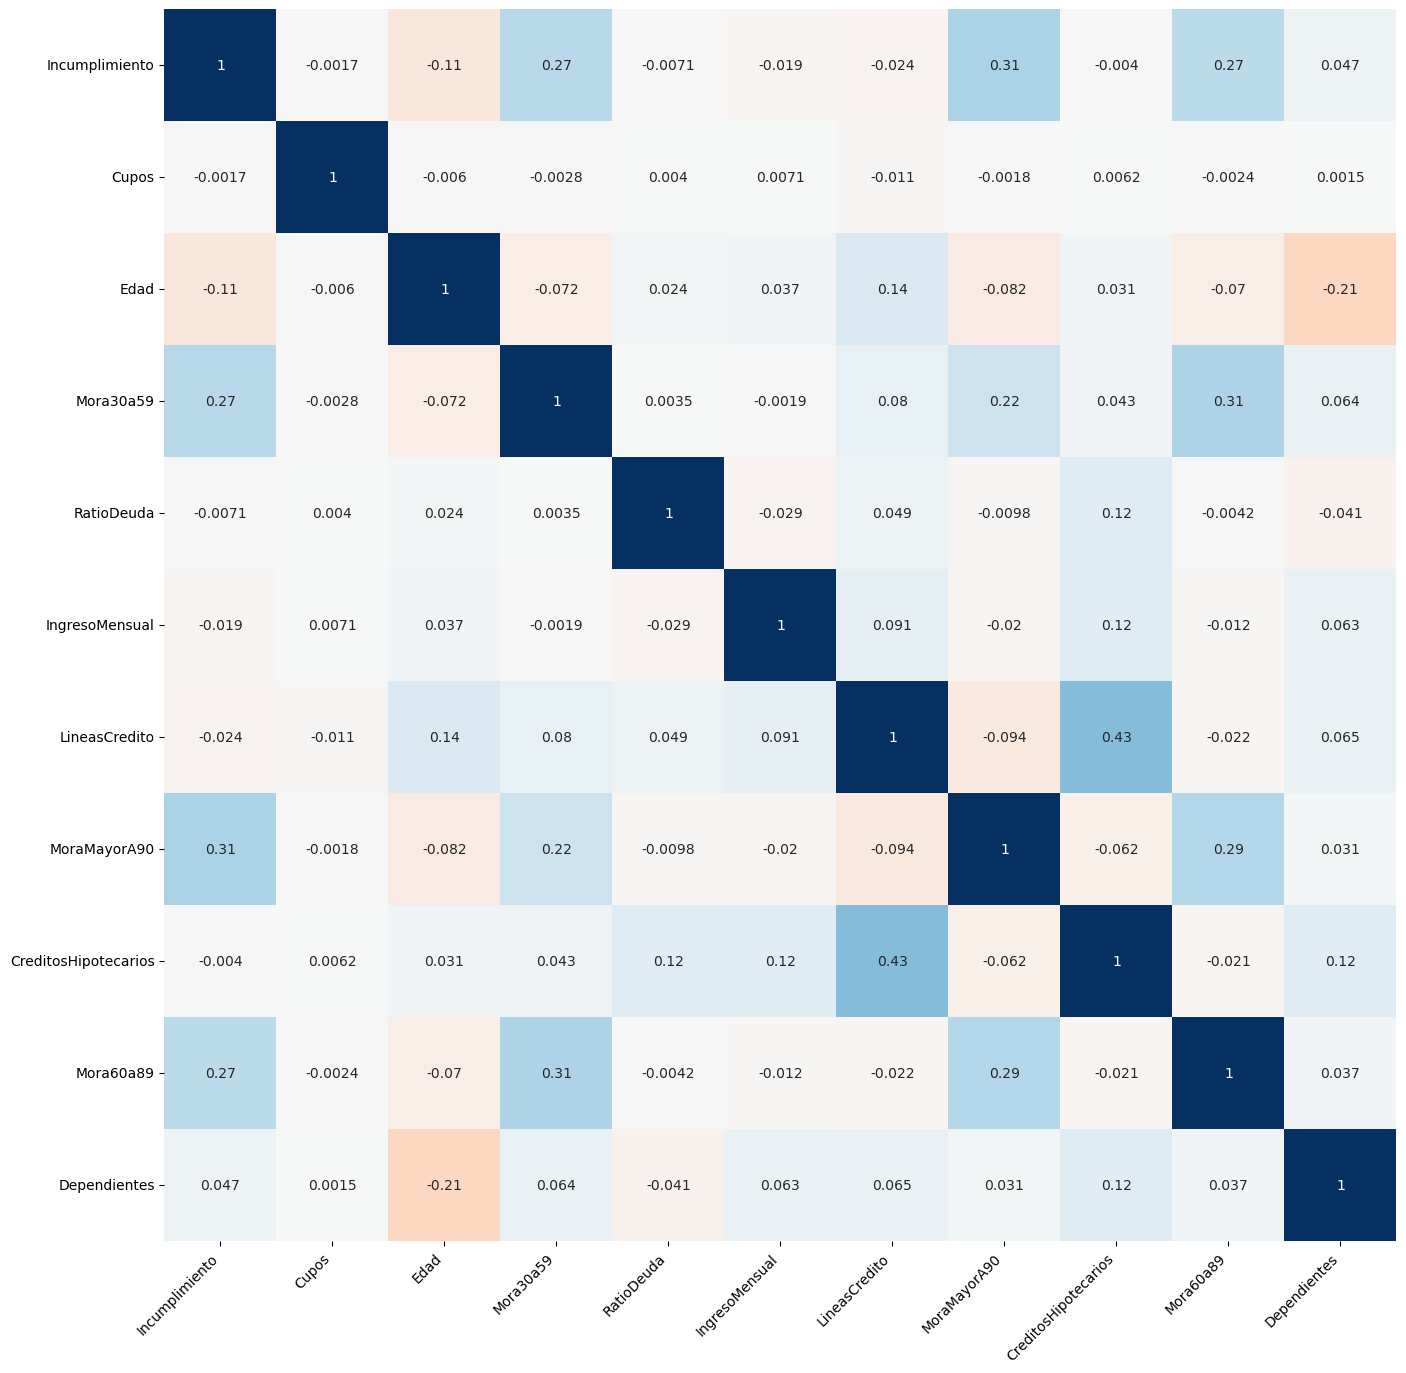

In [90]:
# Mapa de calor (Heatmap) de la matriz de correlaciones

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Al eliminar los valores atípicos de las variables temporales `Mora30a59` y `Mora60a89` se puede observar como se suaviza la correlación de estas variables, pasando de ~0.98 a ~0.20. Sin embargo, se sigue evidenciando que estas variables tienen una correlación importante, por lo que tienen cierta redundancia. A pesar de esto, estas variables aportan información diferente al modelo por lo que no se toma la decisión de eliminarla, se emplea mejor la estrategia de crear una nueva variable.

In [11]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','int32','int64']).columns.tolist()

#Se elimina el elemento bad_credit de la lista de variables Categóricas
numCols.remove('SeriousDlqin2yrs')

d[numCols].head()


,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


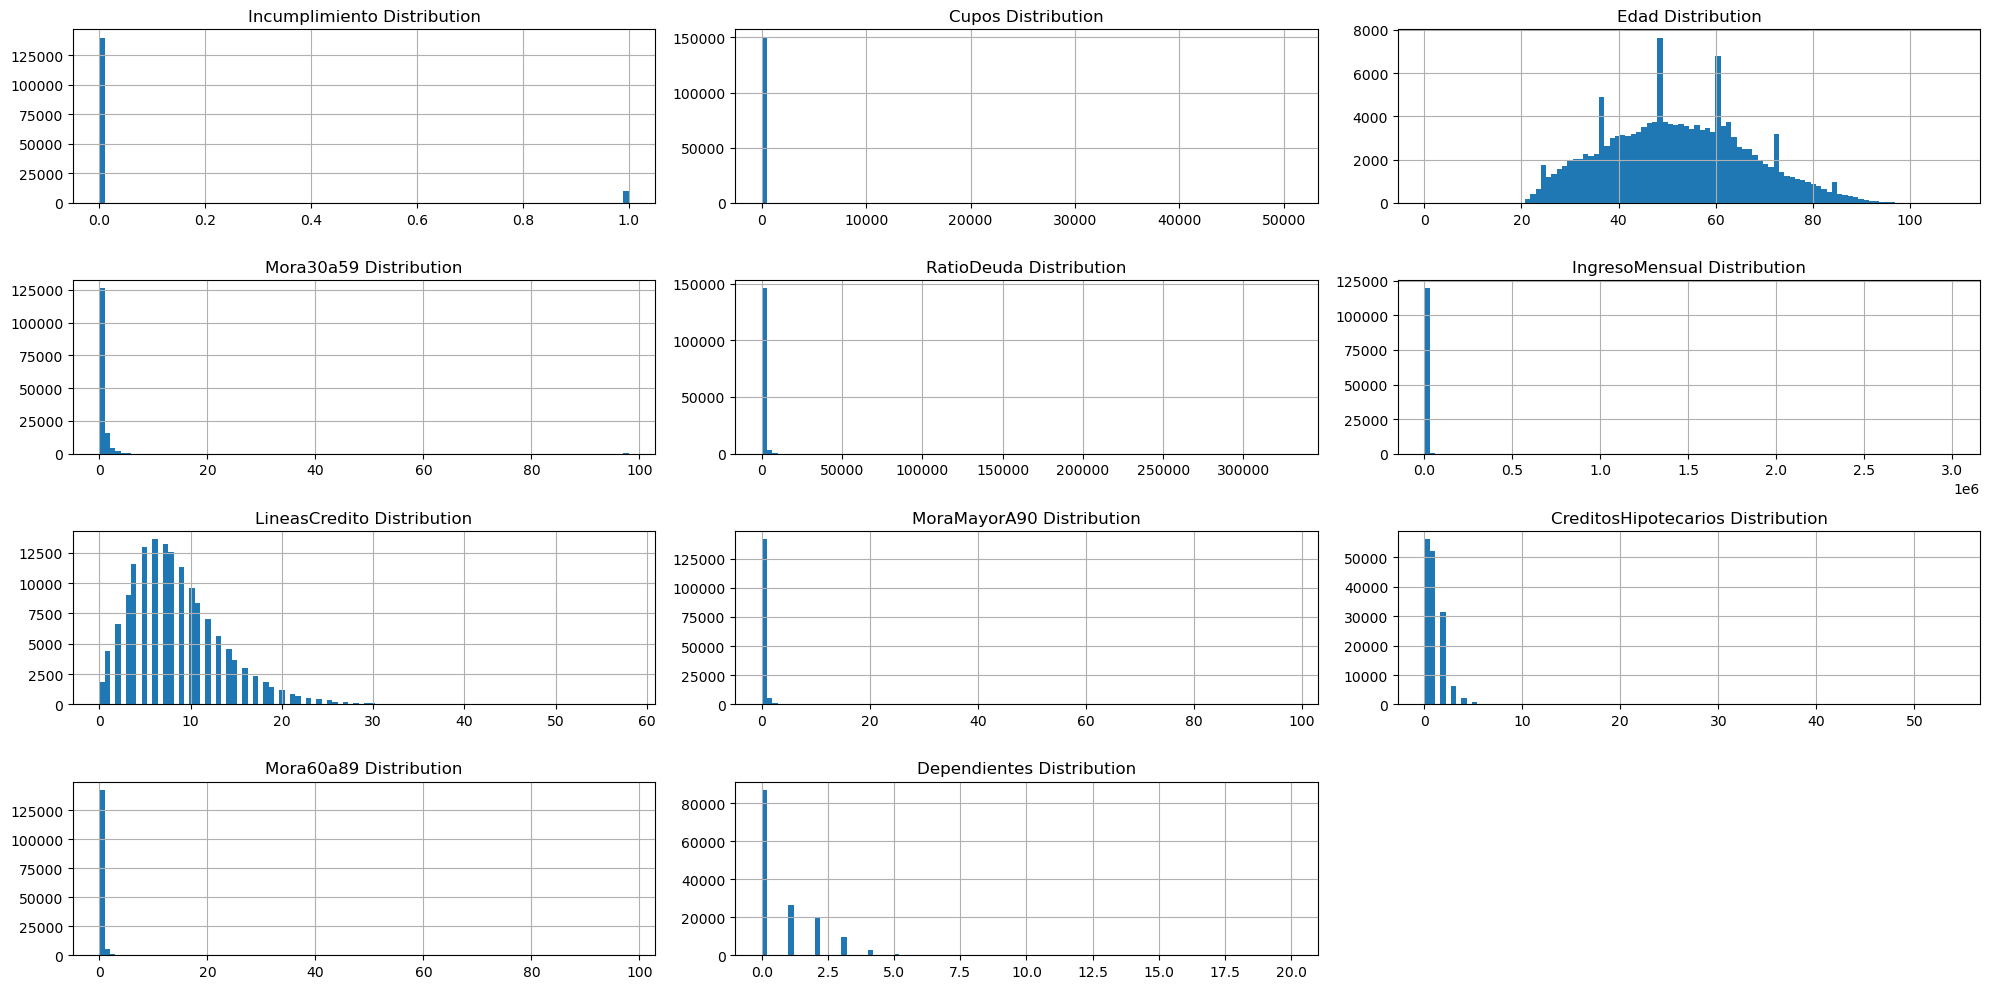

In [28]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=100,ax=ax)
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        ax.xaxis.label.set_color('black')  
        ax.yaxis.label.set_color('black')          
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


draw_histograms(d, d.columns, 4, 3)

In [13]:
d.describe()

,SeriousDlqin2yrs,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Se encuentra un único registro con `Edad` igual a cero que es imputado con la media de esta variable. Los valores desconocidos de `Ingreso Mensual` son remplazados por la media. Por ultimo los valores nulos de `Dependientes` son imputados con la media de la caracteristica.

In [14]:
def imputaciones(): 
    d.loc[d["Edad"] == 0, "Edad"] = d["Edad"].median()
    d["IngresoMensual"] = d["IngresoMensual"].replace(np.nan, d["IngresoMensual"].median())
    d["Dependientes"].fillna(d["Dependientes"].median(), inplace=True)
imputaciones()

In [15]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SeriousDlqin2yrs      150000 non-null  int64  
 1   Cupos                 150000 non-null  float64
 2   Edad                  150000 non-null  int64  
 3   Mora30a59             150000 non-null  int64  
 4   RatioDeuda            150000 non-null  float64
 5   IngresoMensual        150000 non-null  float64
 6   LineasCredito         150000 non-null  int64  
 7   MoraMayorA90          150000 non-null  int64  
 8   CreditosHipotecarios  150000 non-null  int64  
 9   Mora60a89             150000 non-null  int64  
 10  Dependientes          150000 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


### Detección de atípicos

In [16]:
# crear un objeto LocalOutlierFactor con n_neighbors=14
lof = LocalOutlierFactor(n_neighbors=14, contamination=0.1)

y_pred = lof.fit_predict(d[numCols])

outliers = y_pred == -1

print(f"Valores atípicos detectados: {np.count_nonzero(outliers)}")
#print('Indices de valores atípicos: ', d[outliers].index.tolist())

Valores atípicos detectados: 15000


In [17]:
df = d[~outliers]

In [43]:
df.describe()

,SeriousDlqin2yrs,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes
count,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000
mean,0.059978,3.251146,52.178541,0.290156,360.498768,6255.201681,8.110393,0.145644,0.995578,0.130311,0.721459
std,0.237447,122.056926,14.359014,2.780406,1126.521941,5622.549191,4.543916,2.742489,1.046736,2.732551,1.078992
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029158,41.000000,0.000000,0.179260,3945.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.148095,52.000000,0.000000,0.369687,5400.000000,7.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.542595,62.000000,0.000000,0.935610,7229.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,11843.000000,99.000000,98.000000,40385.000000,304000.000000,48.000000,98.000000,32.000000,98.000000,10.000000


In [18]:
# Exportar df a csv
nombre_archivo = 'data/Preprocessed.csv'

df.to_csv(nombre_archivo, index=False)